# Data Exploration

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [3]:
test = np.load("./Data/test_images.npy")
test.shape

(10000, 28, 28)

In [4]:
train = np.load("./Data/train_images.npy")
train.shape

(60000, 28, 28)

In [5]:
labels = pd.read_csv("./Data/train_labels.csv")
labels.shape

(60000, 1)

In [6]:
train_X = train[:50000]
test_X = train[50000:]
train_y = labels[:50000].to_numpy()
test_y = labels[50000:].to_numpy()

Text(0.5, 1.0, 'Data Distribution')

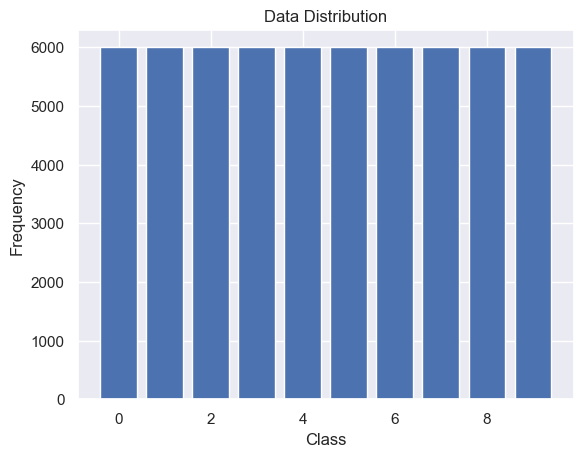

In [7]:
classes, frequency = np.unique(labels, return_counts=True)
plt.bar(classes, frequency)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Data Distribution")

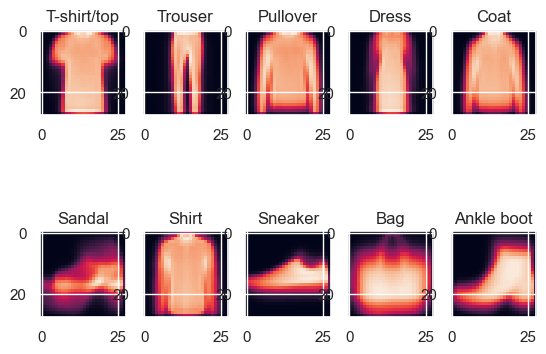

In [8]:
fig, axs = plt.subplots(2, 5)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
meanImg = [train[labels.label.values == k].mean(axis=0).reshape(28,28) for k in range(10)]
for i in range(2):
    for j in range(5):
        axs[i][j].set_title(classes[5*i+j])
        axs[i][j].imshow(meanImg[5*i+j])

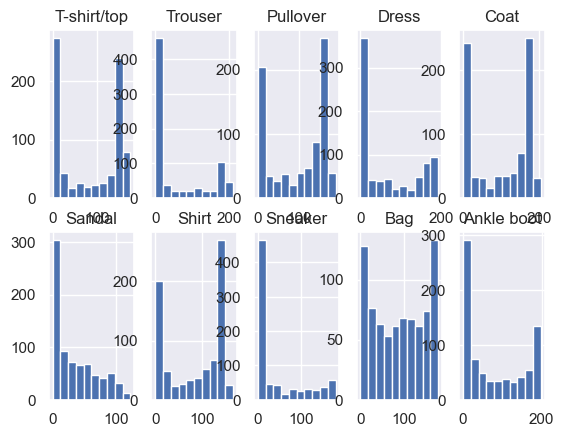

In [9]:
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        axs[i][j].set_title(classes[5*i+j])
        lst = meanImg[5*i+j].flatten()
        axs[i][j].hist(lst)

Extra Analysis

In [18]:
data = train / 255.0
target = labels
data.shape

(60000, 28, 28)

In [27]:
import umap

embedding = umap.UMAP().fit_transform(data, y=target)

SystemError: initialization of _internal failed without raising an exception

ValueError: 'c' argument has 7840000 elements, which is inconsistent with 'x' and 'y' with size 28.

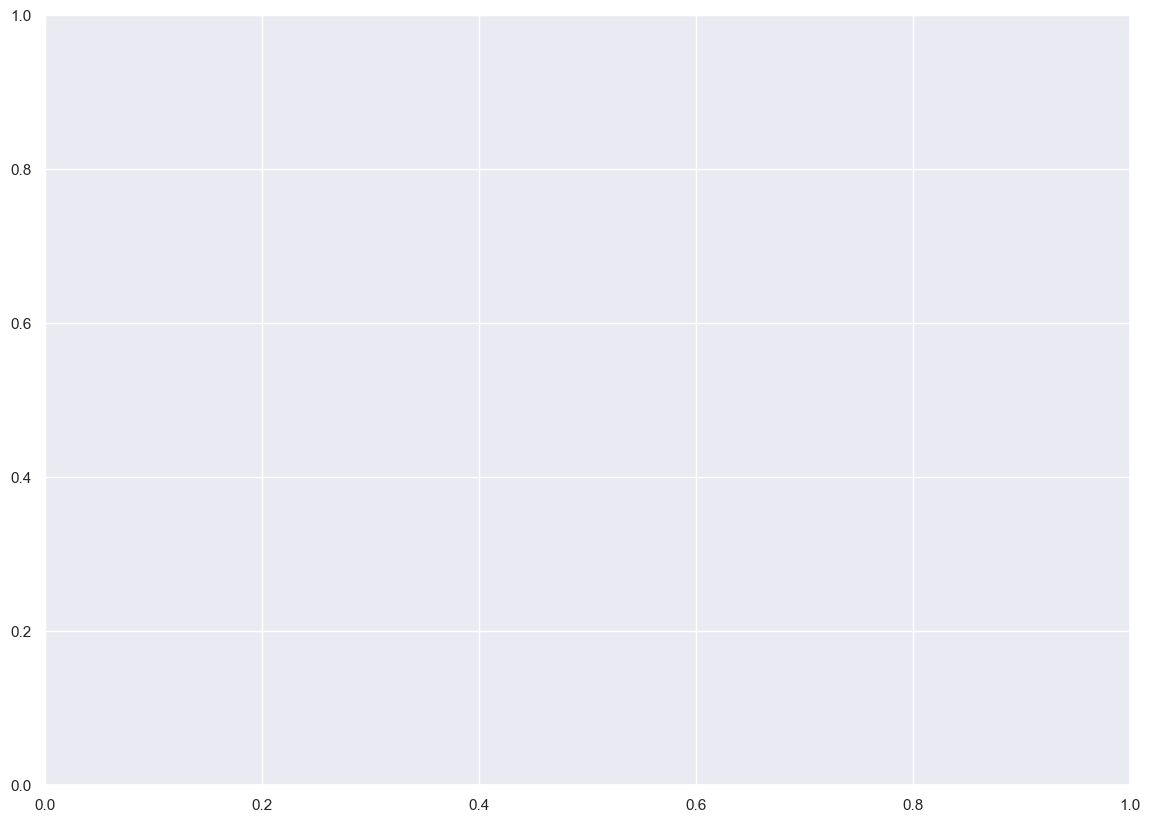

In [276]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Labels');

# Model Exploration

In [126]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [99]:
y_sparse_train = [[0 if train_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(train_y))]
y_sparse_train = np.array(y_sparse_train)
y_sparse_test = [[0 if test_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(test_y))]
y_sparse_test = np.array(y_sparse_test)

Base model (before enhancement)

In [181]:
callbackES = EarlyStopping(monitor='accuracy', patience=3)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dense(50, activation="elu", kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_49 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_117 (Ba  (None, 784)              3136      
 tchNormalization)                                               
                                                                 
 dense_117 (Dense)           (None, 50)                39250     
                                                                 
 batch_normalization_118 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 dense_118 (Dense)           (None, 10)                510       
                                                                 
Total params: 43,096
Trainable params: 41,428
Non-tra

In [182]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0002), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 32, epochs=20)

Epoch 1/20
1520/1563 [============================>.] - ETA: 0s - loss: 0.6247 - accuracy: 0.7862

KeyboardInterrupt: 

In [149]:
model.save("./Model/FashionMNISTBase")

INFO:tensorflow:Assets written to: ./Model/FashionMNISTBase\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTBase\assets


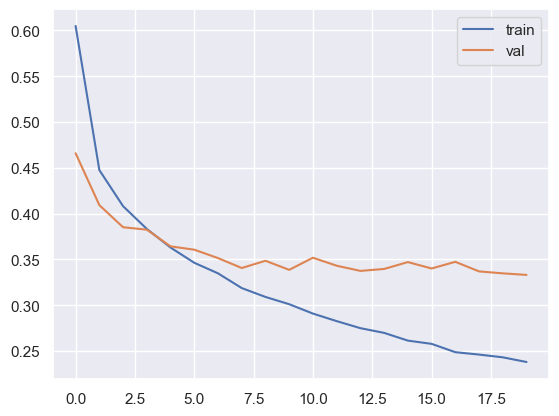

In [161]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

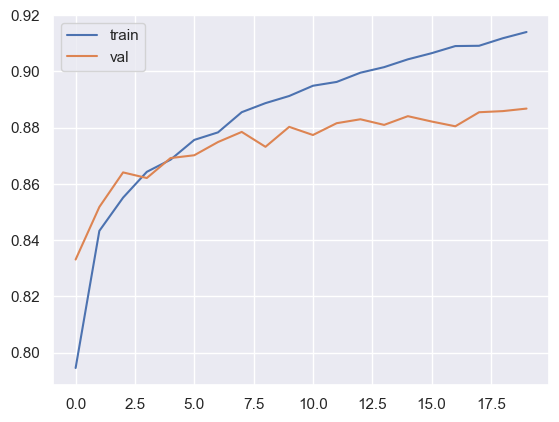

In [162]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()

# Model Enhancement

In [119]:
from tensorflow.keras.models import load_model

## Accuracy vs LR

La prueba se realizo dos veces para un ajuste mas fino del LR

In [121]:
model = load_model("./Model/FashionMNISTBase")
lr = 0.0000016
acc_valResults = []

for i in range(10):
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=lr), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 32, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    lr = lr/5


Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2576 - accuracy: 0.9070 - val_loss: 0.3423 - val_accuracy: 0.8808
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2499 - accuracy: 0.9085 - val_loss: 0.3463 - val_accuracy: 0.8817
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2473 - accuracy: 0.9112 - val_loss: 0.3467 - val_accuracy: 0.8825
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2475 - accuracy: 0.9106 - val_loss: 0.3672 - val_accuracy: 0.8819
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2448 - accuracy: 0.9121 - val_loss: 0.3427 - val_accuracy: 0.8826
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2440 - accuracy: 0.9118 - val_loss: 0.3438 - val_accuracy: 0.8835
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2442 - accuracy: 0.9114 - val_loss: 0.3611 - val_accuracy:

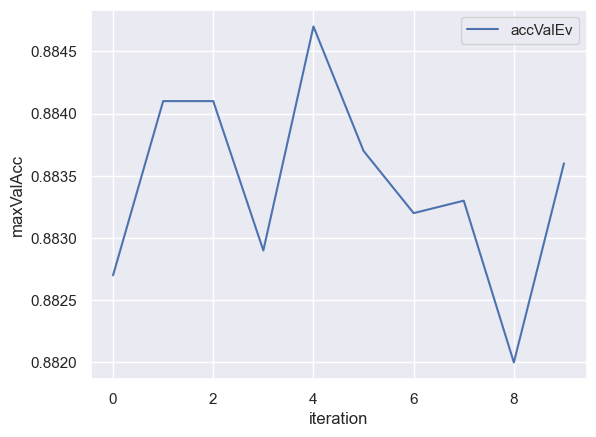

In [122]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## Accuracy vs Batchsize


In [134]:
bz = 32
acc_valResults = []

for i in range(5):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = bz, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    bz = bz*2

Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2638 - accuracy: 0.9051 - val_loss: 0.3458 - val_accuracy: 0.8823
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2567 - accuracy: 0.9078 - val_loss: 0.3463 - val_accuracy: 0.8824
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2581 - accuracy: 0.9062 - val_loss: 0.3385 - val_accuracy: 0.8831
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2569 - accuracy: 0.9084 - val_loss: 0.3397 - val_accuracy: 0.8830
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2550 - accuracy: 0.9077 - val_loss: 0.3392 - val_accuracy: 0.8832
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2533 - accuracy: 0.9099 - val_loss: 0.3403 - val_accuracy: 0.8827
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2547 - accuracy: 0.9086 - val_loss: 0.3396 - val_accuracy:

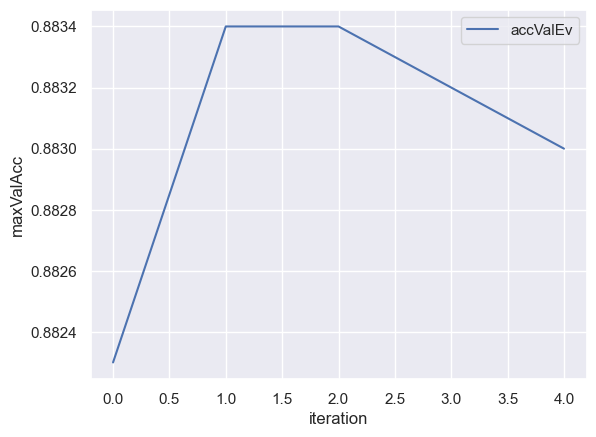

In [135]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

In [136]:
opts = [SGD(0.0000016), RMSprop(0.0000016), Adam(0.0000016), Adagrad(0.0000016)]
acc_valResults = []

for i in range(4):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=opts[i], metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 64, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.2457 - accuracy: 0.9108 - val_loss: 0.3537 - val_accuracy: 0.8798
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3454 - val_accuracy: 0.8801
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3430 - val_accuracy: 0.8805
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2462 - accuracy: 0.9105 - val_loss: 0.3443 - val_accuracy: 0.8805
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2460 - accuracy: 0.9105 - val_loss: 0.3437 - val_accuracy: 0.8804
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2455 - accuracy: 0.9111 - val_loss: 0.3427 - val_accuracy: 0.8806
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3431 - val_accuracy: 0.8812
Epoch 

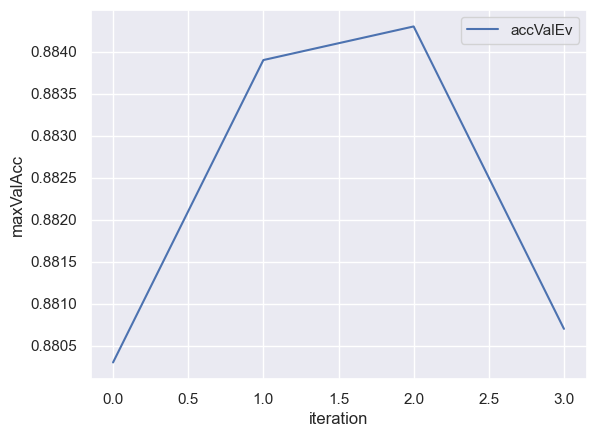

In [137]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## Accuracy vs Activations

In [153]:
activs = ["exponential","relu", "elu", "sigmoid", "tanh", "selu"]

for i in range(len(activs)):
    callbackES = EarlyStopping(monitor='accuracy', patience=3)
    initializer = GlorotNormal()
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(BatchNormalization())
    model.add(Dense(40, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 64, epochs=100)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/100
782/782 [==============================] - 4s 4ms/step - loss: 2.8342 - accuracy: 0.1132 - val_loss: 6.0838 - val_accuracy: 0.1407
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 2.5147 - accuracy: 0.1796 - val_loss: 8.7870 - val_accuracy: 0.2162
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 2.2484 - accuracy: 0.2506 - val_loss: 5.9614 - val_accuracy: 0.3128
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 2.0337 - accuracy: 0.3242 - val_loss: 4.8690 - val_accuracy: 0.3816
Epoch 5/100
782/782 [==============================] - 3s 3ms/step - loss: 1.8732 - accuracy: 0.3796 - val_loss: 668.4653 - val_accuracy: 0.4229
Epoch 6/100
782/782 [==============================] - 3s 4ms/step - loss: 1.7445 - accuracy: 0.4277 - val_loss: 2.4605 - val_accuracy: 0.4649
Epoch 7/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6435 - accuracy: 0.4660 - val_loss: 5.7447 - val_accuracy: 0.49

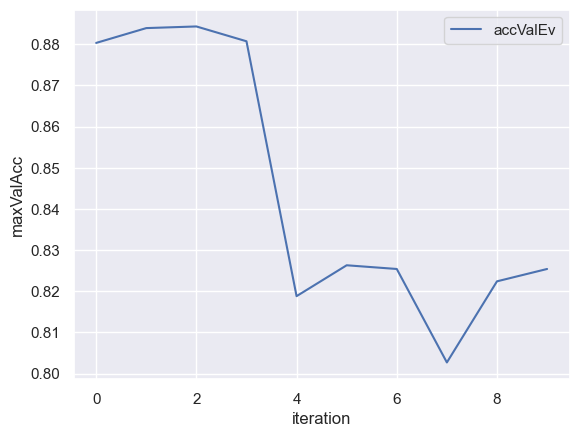

In [154]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

# Model Enhanced Analysis 

In [186]:
callbackES = EarlyStopping(monitor='accuracy', patience=3)
initializer = GlorotNormal()
lr_schedule = ExponentialDecay( initial_learning_rate=0.0002,
                                decay_steps=10000,
                                decay_rate=0.9)
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(50, activation="elu", kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=lr_schedule), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 32, epochs=100)


Epoch 1/100
1563/1563 [==============================] - 6s 3ms/step - loss: 0.6466 - accuracy: 0.7758 - val_loss: 0.4662 - val_accuracy: 0.8372
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4830 - accuracy: 0.8294 - val_loss: 0.4210 - val_accuracy: 0.8475
Epoch 3/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4445 - accuracy: 0.8422 - val_loss: 0.4007 - val_accuracy: 0.8562
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4203 - accuracy: 0.8496 - val_loss: 0.3864 - val_accuracy: 0.8592
Epoch 5/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4037 - accuracy: 0.8585 - val_loss: 0.3756 - val_accuracy: 0.8641
Epoch 6/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3895 - accuracy: 0.8609 - val_loss: 0.3713 - val_accuracy: 0.8655
Epoch 7/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3783 - accuracy: 0.8631 - val_loss: 0.3616 - val_ac

In [187]:
model.save("./Model/FashionMNISTEnhanced")

INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


In [188]:
callbackES = EarlyStopping(monitor='accuracy', patience=3)
initializer = GlorotNormal()
lr_schedule = ExponentialDecay( initial_learning_rate=0.0002,
                                decay_steps=10000,
                                decay_rate=0.9)
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(50, activation="elu", kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(2, activation="elu", kernel_initializer=initializer)) #Esto es asi?
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=lr_schedule), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 32, epochs=100)

Epoch 1/100


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1563/1563 [==============================] - 6s 3ms/step - loss: 1.6427 - accuracy: 0.3560 - val_loss: 1.4397 - val_accuracy: 0.4185
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3754 - accuracy: 0.4664 - val_loss: 1.2492 - val_accuracy: 0.5324
Epoch 3/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2186 - accuracy: 0.5476 - val_loss: 1.0982 - val_accuracy: 0.5849
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1132 - accuracy: 0.5929 - val_loss: 1.0182 - val_accuracy: 0.6562
Epoch 5/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0493 - accuracy: 0.6230 - val_loss: 0.9561 - val_accuracy: 0.6656
Epoch 6/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0028 - accuracy: 0.6450 - val_loss: 0.9224 - val_accuracy: 0.6729
Epoch 7/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9701 - accuracy: 0.6519 - val_loss: 0.8869 - val_accuracy: 0.69

KeyboardInterrupt: 